# DL Indaba Practical 3
# Convolutional Neural Networks
*Developed by Stephan Gouws, Avishkar Bhoopchand & Ulrich Paquet.*

**Introduction**

In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the late 1980s/early 1990s, and have had tremendous success especially with vision (although they have also been used to great success in speech processing pipelines, and more recently, for machine translation). 

We will work to build our mathematical and algorithmic intuition around the "convolution" operation. Then we will construct a deep feedforward convolutional model with which we can classify MNIST digits with over 99% accuracy (our best model yet!).

**Learning objectives**

Understand:
* what a convolutional layer is & how it's different from a fully-connected layer (including the assumptions and trade-offs that are being made), 
* how and when to use convolutional layers (relate it to the assumptions the model makes),
* how backpropagation works through convolutional layers.

**What is expected of you:**

* Read through the explanations and make sure you understand how to implement the convolutional forwards pass.
* Do the same for the backwards phase.
* Train a small model on MNIST.
* At this point, flag a tutor and they will give you access to a GPU instance. Now use the hyperparameters provided to train a state-of-the-art ConvNet model on MNIST.

In [1]:
# Import TensorFlow and some other libraries we'll be using.
import datetime
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

# Import Matplotlib and set some defaults
from matplotlib import pyplot as plt
plt.ioff()
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Download the MNIST dataset onto the local machine.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# ConvNet Architectures
When modelling an image using a regular feed-forward network, we quickly find that the number of model parameters grows exponentially. For example, our 2 layer MNIST feed-forward model from the previous practical already had over 600 000 parameters!

**QUESTION**: How many parameters would a feed-forward network require if it had 2 hidden layers with 512 and 256 neurons respectively, an output size of 10 and an input image of shape [32, 32, 3]?

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3D volume, which applies to images for example). The two key differences between a ConvNet and a Feed-forward network are:
* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth (depth here means the depth of an activation volume, not the depth of a deep neural network!)
* The neurons in each layer are only connected to a small region of the layer before it.

**QUESTION**: Unfortunately there is no such thing as a free lunch. What do you think is the trade-off a ConvNet makes for the reduction in memory required by fewer parameters? 

Generally a ConvNet architecture is made up of different types of layers, the most common being **convolutional layers**, **pooling layers** and **fully connected layers** that we encountered in the last practical. 

ConvNet architectures were key to the tremendous success of deep learning in machine vision. In particular, the first deep learning model to win the ImageNet competition in 2012 was called AlexNet (after Alex Krizhevsky, one of its inventors). It had 5 convolutional layers followed by 3 fully connected layers. Later winners included GoogLeNet and ResNet which also used batch normalisation, a technique we will see in this practical. If you're curious, have a look at [this](https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba) link for a great summary of different ConvNet archiectures. 

We will start by implementing the forward and backward passes of these layers in Numpy to get a good sense for how they work. Afterwards, we will implement a full ConvNet classifier in TensorFlow that we will apply to the MNIST dataset. This model should give us the best test accuracy we've seen so far! 

## Convolutional Layers
A convolutional layer maps an **input volume**\* to an **output volume** through a set of **learnable filters**, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have a set of filters, and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension to produce the output volume. 


The following diagram and animation illustrates these ideas, make sure you understand them!

![Convolutional Layer](images/conv_layer.png)
![Animated Convolutional Layer](images/conv_animation.png)

\* An input volume refers to a 3 dimensional input. For example, a colour image is often represented as a 3 dimensional tensor of shape `[width, height, channels]` where `channels` refers to the colour values. A common colour encoding is RGB which has a value between 0 and 256 for each of the red, green and blue channels.

### What size is the output volume?
The size of the output volume is controlled by the hyperparameters of the convolutional layer:
* **Filter Size** (F) defines the width and height of the filters in the layer. Note that filters always have the same depth as the inputs to the layer.    
* **Depth** (D) of the layer defines the number of filters in the layer. 
* **Stride** (S) defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used. 
* **Padding** (P) refers to the number of 0 pixels we add to the input volume along the width and height dimensions. This parameter is useful in that it gives us more control over the desired size of the output volume and in fact is often used to ensure that the output volume has the same width and height as the input volume. 

If the width of the input volume is $w$, the width of the output volume will be $(w−F+2P)/S+1$. (**QUESTION:** Why?). Similarly for the height ($h$). 

**QUESTION**: What is the final 3D shape of the output volume? 

### Implementing the forward pass
The parameters of a convolutional layer, with padded input $X^{pad}$, are stored in a weight tensor, $W$ of shape $[F, F, I, D]$ and bias vector $b$ of shape $[D]$ where I is the depth of $X$. 
For each filter $d \in [0,D)$ in our convolutional layer, the value of the output volume ($O$) at position $(i, j, d)$ is given by:

\begin{align}
O_{ij}^d = b_{d} + \sum_{a=0}^{F-1} \sum_{b=0}^{F-1} \sum_{c=0}^{I-1} = W_{a, b, c, d} * X^{pad}_{i+a, j+b, c}    && (1)
\end{align}

Don't be put off by all the notation, it's actually quite simple, see if you can tie this formula to the explanation of the convolutional layer and diagrams you saw earlier. 

**QUESTION**: The formula above assumed a stride size of 1 for simplicity. Can you modify the formula to work with an arbitrary stride?

Now let's implement the forward pass of a convolutional layer in Numpy:

In [2]:
## IMPLEMENT-ME: ...

# Conv layer forward pass
def convolutional_forward(X, W, b, filter_size, depth, stride, padding):
    # X has size [batch_size, input_width, input_height, input_depth]
    # W has shape [filter_size, filter_size, input_depth, depth]
    # b has shape [depth]
    batch_size, input_width, input_height, input_depth = X.shape
    
    # Check that the weights are of the expected shape
    assert W.shape == (filter_size, filter_size, input_depth, depth)
    
    # QUESTION: Calculate the width and height of the output
    # output_width = ...
    # output_height = ...
    #
    # ANSWER:
    output_width = (input_width - filter_size + 2*padding) / stride + 1
    output_height = (input_height - filter_size + 2*padding) / stride + 1
    ####
    
    # Apply padding to the width and height dimensions of the input
    X_padded = np.pad(X, ((0,0), (padding, padding), (padding, padding), (0,0)), 'constant')
    
    # Allocate the output Tensor
    out = np.zeros((batch_size, output_width, output_height, depth))
    
    # NOTE: There is a more efficient way of doing a convolution, but this most 
    # clearly illustrates the idea.
    
    for i in range(output_width):    # Loop over the output width dimension
        for j in range(output_height):    # Loop over the output height dimension
            
            # Select the current block in the input that the filter will be applied to 
            block_width_start = i * stride
            block_width_end = block_width_start + filter_size

            block_height_start = j * stride
            block_height_end = block_height_start + filter_size

            block = X_padded[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
            
            for d in range(depth):    # Loop over the filters in the layer (output depth dimension)
                
                filter_weights = W[:, :, :, d]
                # QUESTION: Apply the filter to the block over all inputs in the batch
                # out[:, w, h, f] = ...
                # HINT: Have a look at numpy's sum function and pay attention to the axis parameter
                # ANSWER:
                out[:, i, j, d] = np.sum(block * filter_weights, axis=(1,2,3)) + b[d]
                ###
            
    return out


Let's test our layer on some dummy data:

In [3]:
### Hyperparameters
batch_size = 2
input_width = 4
input_height = 4
input_depth = 3
filter_size = 4
output_depth = 3
stride = 2
padding = 1
###

# Create a helper function that calculates the relative error between two arrays
def relative_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Define the shapes of the input and weights
input_shape = (batch_size, input_width, input_height, input_depth)
w_shape = (filter_size, filter_size, input_depth, output_depth)

# Create the dummy input
X = np.linspace(-0.1, 0.5, num=np.prod(input_shape)).reshape(input_shape)

# Create the weights and biases
W = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=output_depth)

# Get the output of the convolutional layer
out = convolutional_forward(X, W, b, filter_size, output_depth, stride, padding)

correct_out = np.array(
        [[[[8.72013250e-02, 2.37300699e-01, 3.87400074e-01],
             [1.34245123e-01, 2.86133235e-01, 4.38021347e-01]],
            [[8.21928598e-02, 2.39447184e-01, 3.96701509e-01],
             [4.47552448e-04, 1.59490615e-01, 3.18533677e-01]]],
         [[[1.11179021e+00, 1.29050939e+00, 1.46922856e+00],
             [9.01255797e-01, 1.08176371e+00, 1.26227162e+00]],
            [[7.64688995e-02, 2.62343025e-01, 4.48217151e-01],
             [-2.62854619e-01, -7.51917556e-02, 1.12471108e-01]]]])

# Compare your output to the "correct" ones 
# The difference should be around 2e-8 (or lower)

print 'Testing convolutional_forward'
diff = relative_error(out, correct_out)
if diff <= 2e-8:
    print 'PASSED'
else:
    print 'The difference of %s is too high, try again' % diff

Testing convolutional_forward
PASSED


### The derivative of a convolutional layer
Assume we have some final loss function L and by following the steps of backpropagation, have computed the derivative of this loss up to the output of our convolutional layer ($\frac{\partial L}{\partial O}$ or `dout` in the code below). In order to update the parameters of our layer, we require the derivative of L with respect to the weights and biases of the convolutional layer ($\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$). We also require the derivative with respect to the inputs of the layer ($\frac{\partial L}{\partial X}$) in order to propagate the error back to the preceding layers. Unfortunately calculating these derivatives can be a little fiddly due to having to keep track of multiple indices. The calculus is very basic though!

We start with the easiest one, $\frac{\partial L}{\partial b}$:

\begin{align}
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial O} \frac{\partial O}{\partial b} && \vartriangleright \text{(Chain Rule)} \\
 &= \frac{\partial L}{\partial O} \mathbf{1} && \vartriangleright (\frac{\partial O}{\partial b} = 1 \text{ from equation } (1))
\end{align}

Now we tackle $\frac{\partial L}{\partial W}$:

\begin{align}
\frac{\partial L}{\partial W} &= \frac{\partial L}{\partial O} \frac{\partial O}{\partial W} && \vartriangleright \text{(Chain Rule)}
\end{align}

Let's calculate this derivative with respect to a single point $W_{abcd}$ in our weight tensor ($O_w$ and $O_h$ are the output width and height respectively):

\begin{align}
\frac{\partial L}{\partial W_{abcd}} &= \sum_{i=0}^{O_w-1} \sum_{j=0}^{O_h-1} \frac{\partial L}{\partial O_{ij}^d} \frac{\partial O_{ij}^d}{\partial W_{abcd}}
\end{align}

**QUESTION**: Why do we sum over the outputs here? **HINT**: Think about how many times a particular weight gets used. 

Now, looking at equation $(1)$, we can easily calculate $\frac{\partial O_{ij}^d}{\partial W_{abcd}}$ as: 

\begin{align}
\frac{\partial O_{ij}^d}{\partial W_{abcd}} &= X^{pad}_{i+a, j+b, c}
\end{align}

Which gives a final result of:

\begin{align}
\frac{\partial L}{\partial W_{abcd}} &= \sum_{i=0}^{O_w-1} \sum_{j=0}^{O_h-1} \frac{\partial L}{\partial O_{ij}^d} X^{pad}_{i+a, j+b, c}
\end{align}

Finally, we need $\frac{\partial L}{\partial X}$, the derivative of the loss with respect to the **input** of the layer. This is sometimes also called a "delta". Remember, that before doing the convolution, we applied padding to the input $X$ to get $X^{pad}$. It's easier to calculate the derivative with respect to $X^{pad}$, which appears in our convolution equation, and then remove the padding later on to arrive at the delta. Unfortunately we need to introduce some *more* indexing for the individual components of $X^{pad}$:

\begin{align}
\frac{\partial L}{\partial X^{pad}_{mnc}} &= \sum_{i=0}^{O_w-1} \sum_{j=0}^{O_h-1} \sum_{d=0}^{D-1} W_{m-i, n-j, c, d} \frac{\partial L}{\partial O_{ij}^d} 
\end{align}

Where do the indices $m-i$ and $n-j$ come from? Notice in equation $(1)$ that the padded input $X^{pad}_{i+a, j+b, c}$ is multiplied by the weight $W_{abcd}$. Now, when we index $X^{pad}$ with $m$ and $n$, setting $m=i+a$ and $n=j+b$ gives us $a=m-i$ and $b=n-j$ for the indices of $W$! 

Phew! Spend a few minutes to understand these equations, particularly where the indices come from. Ask a tutor if you get stuck!

Note: Did you notice that the delta, $\frac{\partial L}{\partial X^{pad}_{mnc}}$ looks suspiciously like the convolutional forward equation with the inputs $X^{pad}$ replaced by $\frac{\partial L}{\partial O_{ij}^d}$ and different indexing into the weights? In fact the delta is exactly that, the forward convolution applied to the incoming derivative, with the filters flipped along the width and height axes. 

Now let's implement this in Numpy:

In [6]:
## IMPLEMENT-ME: ...

def convolutional_backward(dout, X, W, b, filter_size, depth, stride, padding):
    batch_size, input_width, input_height, input_depth = X.shape
    
    # Apply padding to the width and height dimensions of the input
    X_padded = np.pad(X, ((0,0), (padding, padding), (padding, padding), (0,0)), 'constant')
    
    # Calculate the width and height of the forward pass output
    output_width = (input_width - filter_size + 2*padding) / stride + 1
    output_height = (input_height - filter_size + 2*padding) / stride + 1
    
    # Allocate output arrays
    # QUESTION: What is the shape of dx? dw? db?
    # ANSWER: ...
    dx_padded = np.zeros_like(X_padded) 
    dw = np.zeros_like(W)
    db = np.zeros_like(b)
    
    # QUESTION: Calculate db, the derivative of the final loss with respect to the bias term
    # HINT: Have a look at the axis parameter of the np.sum function.
    db = np.sum(dout, axis = (0, 1, 2))
    
    for i in range(output_width):
        for j in range(output_height):
            
            # Select the current block in the input that the filter will be applied to 
            block_width_start = i*stride
            block_width_end = block_width_start+filter_size

            block_height_start = j*stride
            block_height_end = block_height_start + filter_size

            block = X_padded[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
            
            for d in range(depth):
                # QUESTION: Calculate dw[:,:,:,f], the derivative of the loss with respect to the weight parameters of the f'th filter.
                # HINT: You can do this in a loop if you prefer, or use np.sum and "None" indexing to get your result to the correct 
                # shape to assign to dw[:,:,:,f], see (https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis)
                dw[:,:,:,d] += np.sum(block*(dout[:,i,j,d])[:,None,None,None], axis=0)
                
            dx_padded[:,block_width_start:block_width_end, block_height_start:block_height_end, :] += np.einsum('ij,klmj->iklm', dout[:,i,j,:], W)
            
        # Now we remove the padding to arrive at dx
        dx = dx_padded[:,padding:-padding, padding:-padding, :]
        
    return dx, dw, db
    

Finally, we test the backward pass using numerical gradient checking. This compares the gradients generated by our backward function, with a numerical approximation obtained by treating our forward function as a "black box". This gradient checking is a very important testing tool when building your own neural network components or back-propagation system! 

In [7]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
        """
        Evaluate a numeric gradient for a function that accepts a numpy
        array and returns a numpy array.
        """
        
        # QUESTION: Can you describe intuitively what this function is doing? 
        
        grad = np.zeros_like(x)
        it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index

            oldval = x[ix]
            x[ix] = oldval + h
            pos = f(x).copy()
            x[ix] = oldval - h
            neg = f(x).copy()
            x[ix] = oldval

            grad[ix] = np.sum((pos - neg) * df) / (2 * h)
            it.iternext()
        return grad

np.random.seed(231)

# Normally, backpropagation will have calculated a derivative of the final loss with respect to 
# the output of our layer. Since we're testing our layer in isolation here, we'll just pretend
# and use a random value
dout = np.random.randn(2, 2, 2, 3)

dx_num = eval_numerical_gradient_array(lambda x: convolutional_forward(X, W, b, filter_size, output_depth, stride, padding), X, dout)
dw_num = eval_numerical_gradient_array(lambda w: convolutional_forward(X, W, b, filter_size, output_depth, stride, padding), W, dout)
db_num = eval_numerical_gradient_array(lambda b: convolutional_forward(X, W, b, filter_size, output_depth, stride, padding), b, dout)

out = convolutional_forward(X, W, b, filter_size, output_depth, stride, padding)
dx, dw, db = convolutional_backward(dout, X, W, b, filter_size, output_depth, stride, padding)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')

dx_diff = relative_error(dx, dx_num)
if dx_diff < 1e-8:
    print 'dx check: PASSED'
else:
    print 'The difference of %s on dx is too high, try again!' % dx_diff
    
dw_diff = relative_error(dw, dw_num)
if dw_diff < 1e-8:
    print 'dw check: PASSED'
else:
    print 'The difference of %s on dw is too high, try again!' % dw_diff
    
db_diff = relative_error(db, db_num)
if db_diff < 1e-8:
    print 'db check: PASSED'
else:
    print 'The difference of %s on db is too high, try again!' % db_diff
    

Testing conv_backward_naive function
dx check: PASSED
dw check: PASSED
db check: PASSED


## (Max) Pooling Layers
The purpose of a pooling layer is to is to reduce the spatial size of the representation and therefore control the number of parameters in the network. A pooling layer has no trainable parameters itself. It applies some 2D aggegation operation (usually a MAX, but others like average may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height. 

The output volume of a pooling layer alwyas has the same depth as the input volume. The width and height are calcualted as follows:
$(W−F)/S+1$ where W is the width/height of the 

### Implementing the forward pass
We again implement this in Numpy:

In [8]:
def max_pool_forward(X, pool_size, stride):
    batch_size, input_width, input_height, input_depth = X.shape
    
    # Calculate the output dimensions
    output_width = (input_width - pool_size)/stride + 1
    output_height = (input_height - pool_size)/stride + 1
    
    # Allocate the output array
    out = np.zeros((batch_size, output_width, output_height, input_depth))
    
    # Select the current block in the input that the filter will be applied to 
    for w in range(output_width):
        for h in range(output_height):
            block_width_start = w*stride
            block_width_end = block_width_start+pool_size

            block_height_start = h*stride
            block_height_end = block_height_start + pool_size

            block = X[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
            ## IMPLEMENT-ME CANDIDATE
            out[:,w,h,:] = np.max(block, axis=(1,2))
            
    return out


Now we can test the `max_pool_forward` function.

In [9]:
### Hyperparameters
batch_size = 2
input_width = 4
input_height = 4
input_depth = 3
pool_size = 2
stride = 2
###

input_shape = (batch_size, input_width, input_height, input_depth)
X = np.linspace(-0.3, 0.4, num=np.prod(input_shape)).reshape(input_shape)

out = max_pool_forward(X, pool_size, stride)

correct_out = np.array([
        [[[-0.18947368, -0.18210526, -0.17473684],
            [-0.14526316, -0.13789474, -0.13052632]],
         [[-0.01263158, -0.00526316, 0.00210526],
            [0.03157895, 0.03894737, 0.04631579]]],
        [[[0.16421053, 0.17157895, 0.17894737],
            [0.20842105, 0.21578947, 0.22315789]],
         [[0.34105263, 0.34842105, 0.35578947],
            [0.38526316, 0.39263158, 0.4]]]])

# Compare the output. The difference should be less than 1e-6.
print('Testing max_pool_forward function:')
diff = relative_error(out, correct_out)
if diff < 1e-6:
    print 'PASSED'
else:
    print 'The difference of %s is too high, try again!' % diff

Testing max_pool_forward function:
PASSED


### The derivative of a max-pool layer

The max-pooling layer has no learnable parameters of its own, so the only derivative of concern is that of the output of the layer with respect to the input for the purpose of backpropagating the error through the layer. This is easy to calculate as it only requires that we recalculate (or remember) which value in each block was the maximum. Since each output depends only on one value in some FxF block of the input, the gradients of the max-pool layer will be sparse. 

Let's implement the backward pass in Numpy:

In [10]:
def max_pool_backward(dout, X, max_pool_output, pool_size, stride):
    batch_size, input_width, input_height, input_depth = X.shape
    
    # Calculate the output dimensions
    output_width = (input_width - pool_size)/stride + 1
    output_height = (input_height - pool_size)/stride + 1
    
    # QUESTION: What is the size of dx, the derivative with respect to x? 
    # Allocate an array to hold the derivative
    dx = np.zeros_like(X)
    
    for w in range(output_width):
        for h in range(output_height):
            # Which block in the input did the value at the forward pass output come from?
            block_width_start = w*stride
            block_width_end = block_width_start+pool_size

            block_height_start = h*stride
            block_height_end = block_height_start + pool_size

            block = X[:, block_width_start:block_width_end, block_height_start:block_height_end, :]
            
            # What was the maximum value
            max_val = max_pool_output[:, w, h, :]
            
            # Which values in the input block resulted in the output?
            responsible_values = block == max_val[:, None, None, :]
            
            # Add the contribution of the current block to the gradient
            dx[:,block_width_start:block_width_end,block_height_start:block_height_end, :] += responsible_values * (dout[:,w,h,:])[:,None,None,:]
            
    return dx

And we again use numerical gradient checking to ensure that the backward function is correct: 

In [11]:
# Define a hypothetical derivative of the loss function with respect to the output of the max-pooling layer.
dout = np.random.randn(batch_size, pool_size, pool_size, input_depth)

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward(x, pool_size, stride), X, dout)
out = max_pool_forward(X, pool_size, stride)
dx = max_pool_backward(dout, X, out, pool_size, stride)

# Your error should be less than 1e-12
print('Testing max_pool_backward function:')
diff = relative_error(dx, dx_num)
if diff < 1e-12:
    print 'PASSED'
else:
    print 'The diff of %s is too large, try again!' % diff

Testing max_pool_backward function:
PASSED


## Optimisation - an exercise for later
Our implementations of convolutional and max-pool layers were based on loops, which are easy to understand, but are slow and inefficient compared to a vectorised implementation exploiting matrix multiplications. The vectorised form is how these layers are actually implemented in practice and are also required to make efficient use of GPUs in frameworks that support it, like TensorFlow. As an exercise, once you fully understand how the layers work, try to rewrite the code such that the convolution and max-pool operations are each implemented in a **single matrix multiplication**. 

(HINT: Matlab has a function called "im2col" that rearranges blocks of an image into columns, you will need to achieve something similar using Numpy!)

# Building a 2-layer ConvNet in TensorFlow

Now that we understand the convolutional and max pool layers, let's switch back to TensorFlow and build a 2-layer ConvNet classifier that we can apply to MNIST. We reuse essentially the same classifier framework we used in Practical 2 as well as the training and plotting functions, but we have added support for 2 new forms of regularisation, **dropout** and **batch normalisation**. These are explained in more detail later.

In [12]:
class BaseSoftmaxClassifier(object):
    def __init__(self, input_size, output_size):        
        # Define the input placeholders. The "None" dimension means that the 
        # placeholder can take any number of images as the batch size. 
        self.x = tf.placeholder(tf.float32, [None, input_size])
        self.y = tf.placeholder(tf.float32, [None, output_size])    
        
        # We add an additional input placeholder for Dropout regularisation
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        
        # And one for bath norm regularisation
        self.is_training = tf.placeholder(tf.bool, name="is_training")
        
        self.input_size = input_size
        self.output_size = output_size
        
        # You should override these in your build_model() function.
        self.logits = None
        self.predictions = None
        self.loss = None
        
        self.build_model()
        
    def get_logits(self):
        return self.logits
    
    def build_model(self):
        # OVERRIDE THIS FOR YOUR PARTICULAR MODEL.
        raise NotImplementedError("Subclasses should implement this function!")
        
    def compute_loss(self):
        """All models share the same softmax cross-entropy loss."""
        assert self.logits is not None    # Ensure that logits has been created! 
        data_loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
            
        return data_loss
    
    def accuracy(self):
        # Calculate accuracy.
        assert self.predictions is not None    # Ensure that pred has been created!
        correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        return accuracy

Lets also bring in the training and plotting routines we developed in Prac 2:

In [13]:
def train_tf_model(tf_model,                                     
                   session,    # The active session.
                   num_epochs,    # Max epochs/iterations to train for.
                   batch_size=100,    # Number of examples per batch.
                   keep_prob=1.0,    # (1. - dropout) probability, none by default.
                   optimizer_fn=None,    # TODO(sgouws): more correct to call this optimizer_obj
                   report_every=1, # Report training results every nr of epochs.
                   eval_every=1,    # Evaluate on validation data every nr of epochs.
                   stop_early=True,    # Use early stopping or not.
                   verbose=True): 

    # Get the (symbolic) model input, output, loss and accuracy.
    x, y = tf_model.x, tf_model.y
    loss = tf_model.loss
    accuracy = tf_model.accuracy()

    # Compute the gradient of the loss with respect to the model parameters 
    # and create an op that will perform one parameter update using the specific
    # optimizer's update rule in the direction of the gradients.
    if optimizer_fn is None:
        optimizer_fn = tf.train.AdamOptimizer(1e-4)
        
    # For batch normalisation: Ensure that the mean and variance tracking 
    # variables get updated at each training step
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer_step = optimizer_fn.minimize(loss)

    # Get the op which, when executed, will initialize the variables.
    init = tf.global_variables_initializer()
    # Actually initialize the variables (run the op).
    session.run(init)

    # Save the training loss and accuracies on training and validation data.
    train_costs = []
    train_accs = []
    val_costs = []
    val_accs = []

    mnist_train_data = mnist.train
    
    prev_c_eval = 1000000
    
    # Main training cycle.
    for epoch in range(num_epochs):

        avg_cost = 0.
        avg_acc = 0.
        total_batch = int(mnist.train.num_examples / batch_size)

        # Loop over all batches.
        for i in range(total_batch):
            batch_x, batch_y = mnist_train_data.next_batch(batch_size)
                        
            # Run optimization op (backprop) and cost op (to get loss value),
            # and compute the accuracy of the model.
            feed_dict = {x: batch_x, y: batch_y, tf_model.keep_prob: keep_prob,
                                    tf_model.is_training: True}
            _, c, a = session.run(
                    [optimizer_step, loss, accuracy], feed_dict=feed_dict)
                        
            # Compute average loss/accuracy
            avg_cost += c / total_batch
            avg_acc += a / total_batch            
        
        train_costs.append((epoch, avg_cost))
        train_accs.append((epoch, avg_acc))

        # Display logs per epoch step
        if epoch % report_every == 0 and verbose:
            print "Epoch:", '%04d' % (epoch+1), "Training cost=", \
                        "{:.9f}".format(avg_cost)
                
        if epoch % eval_every == 0:
            val_x, val_y = mnist.validation.images, mnist.validation.labels            
            
            feed_dict = {x : val_x, y : val_y, tf_model.keep_prob: 1.0,
                                    tf_model.is_training: False}
            c_eval, a_eval = session.run([loss, accuracy], feed_dict=feed_dict)
            
            if verbose:
                print "Epoch:", '%04d' % (epoch+1), "Validation acc=", \
                            "{:.9f}".format(a_eval)
                
            if c_eval >= prev_c_eval and stop_early:
                print "Validation loss stopped improving, stopping training early after %d epochs!" % (epoch + 1)
                break
                
            prev_c_eval = c_eval
                
            val_costs.append((epoch, c_eval))
            val_accs.append((epoch, a_eval))
    
    print "Optimization Finished!"
    return train_costs, train_accs, val_costs, val_accs

In [14]:
# Helper functions to plot training progress.

def my_plot(list_of_tuples):
    """Take a list of (epoch, value) and split these into lists of 
    epoch-only and value-only. Pass these to plot to make sure we
    line up the values at the correct time-steps.
    """
    plt.plot(*zip(*list_of_tuples))

def plot_multi(values_lst, labels_lst, y_label, x_label='epoch'):
    # Plot multiple curves.
    assert len(values_lst) == len(labels_lst)
    plt.subplot(2, 1, 2)
    
    for v in values_lst:
        my_plot(v)
    plt.legend(labels_lst, loc='upper left')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Now define some helper functions to build a convolutional layer and a linear layer (this is mostly the same as the previous practical, but we use slightly different weight and bias initializations which seem to work better with ConvNets on MNIST). In terms of regularisation, we use **dropout** rather than the L2 regularisation from the previous practical. 

## Dropout
Dropout is a neural-network regularisation technique that is applied during model training. At each training step, a proportion `(1-keep_prob)` of neurons the network are "dropped out" (their inputs and outputs are set to 0, effectively ignoring their contribution) while the remaining `keep_prob` fraction are "let through" (**Nit**: they're actually rescaled by `1/keep_prob` to ensure that the variance of the pre-activations at the next layer remains unchanged). This can be interpreted as there being actually $2^n$ different network architectures (where n is the number of neurons) while only one is being trained at each training step. At test time, we use the full network, where each neuron's contribution is weighted by `keep_prob`. This is effectively the average of all the network possibilities and therefore dropout can also be thought of as an ensemble technique. 

In our ConvNet architecture, the majority of neurons occur in the fully connected layer between the convolutional layers and the output. It is therefore this fully connected layer that we are most concerned about overfitting and this is where we apply dropout. 

In [15]:
def _convolutional_layer(inputs, filter_size, output_depth):
    """Build a convolutional layer with `output_depth` square 
    filters, each of size `filter_size` x `filter_size`."""

    input_features = inputs.shape[3] 
    
    weights = tf.get_variable(
            "conv_weights", 
            [filter_size, filter_size, input_features, output_depth], 
            dtype=tf.float32,
            initializer=tf.truncated_normal_initializer(stddev=0.1))
     
    ## IMPLEMENT-ME CANDIDATE
    conv = tf.nn.conv2d(inputs, weights, strides=[1, 1, 1, 1], padding='SAME')
    return conv


In [16]:
def _dense_linear_layer(inputs, layer_name, input_size, output_size, weights_initializer):
    """
    Builds a layer that takes a batch of inputs of size `input_size` and returns 
    a batch of outputs of size `output_size`.
         
    Args:
        inputs: A `Tensor` of shape [batch_size, input_size].
        layer_name: A string representing the name of the layer.
        input_size: The size of the inputs
        output_size: The size of the outputs
        
    Returns:
        out, weights: tuple of layer outputs and weights.
        
    """
    # Name scopes allow us to logically group together related variables.
    # Setting reuse=False avoids accidental reuse of variables between different runs.
    with tf.variable_scope(layer_name, reuse=False):
        # Create the weights for the layer
        layer_weights = tf.get_variable("weights",
                                        shape=[input_size, output_size], 
                                        dtype=tf.float32, 
                                        initializer=weights_initializer)
        # Create the biases for the layer
        layer_bias = tf.get_variable("biases", 
                                     shape=[output_size], 
                                     dtype=tf.float32, 
                                     initializer=tf.constant_initializer(0.1))
        
        outputs = tf.matmul(inputs, layer_weights) + layer_bias
    
    return outputs

Now build the ConvNetClassifier, we make the number of convolutional layers and the filter sizes parameters so that you can easily experiment with different variations. 

In [17]:
class ConvNetClassifier(BaseSoftmaxClassifier):
    def __init__(self, 
                 input_size,     # The size of the input
                 output_size,    # The size of the output
                 filter_sizes=[], # The number of filters to use per convolutional layer
                 output_depths=[], # The number of features to output per convolutional layer
                 hidden_linear_size=512,    # The size of the hidden linear layer
                 use_batch_norm=False,     # Flag indicating whether or not to use batch normalisation
                 linear_weights_initializer=tf.truncated_normal_initializer(stddev=0.1)):        
        
        assert len(filter_sizes) == len(output_depths)
        
        self.filter_sizes = filter_sizes
        self.output_depths = output_depths
        self.linear_weights_initializer = linear_weights_initializer
        self.use_batch_norm = use_batch_norm
        self.hidden_linear_size = hidden_linear_size
        
        super(ConvNetClassifier, self).__init__(input_size, output_size)
        
        
    def build_model(self):
        # Architecture: INPUT - {CONV - RELU - POOL}*N - FC
        
        # Reshape the input to [batch_size, width, height, input_depth]
        conv_input = tf.reshape(self.x, [-1, 28, 28, 1])    
        
        prev_inputs = conv_input
        
        # Create the CONV-RELU-POOL layers:
        for layer_number, (layer_filter_size, layer_features) in enumerate(
                zip(self.filter_sizes, self.output_depths)):
            with tf.variable_scope("layer_{}".format(layer_number), reuse=False):
                # Create the convolution:
                conv = _convolutional_layer(prev_inputs, layer_filter_size, layer_features)
                
                # Apply batch normalisation, if required
                if self.use_batch_norm:
                    conv = tf.contrib.layers.batch_norm(conv, center=True, scale=True, 
                                                        is_training=self.is_training)
                
                # Apply the RELU activation with a bias
                bias = tf.get_variable("bias", [layer_features], dtype=tf.float32, initializer=tf.constant_initializer(0.1))
                relu = tf.nn.relu(conv + bias)
                
                # Apply max-pooling using patch-sizes of 2x2
                pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1],
                                                            strides=[1, 2, 2, 1], 
                                                            padding='SAME')
                
                # QUESTION: What is the shape of the pool tensor?
                # ANSWER: ...
                
                prev_inputs = pool
        
        
        # QUESTION: What is the shape of prev_inputs now? 
        
        # We need to flatten the last (non-batch) dimensions of the convolutional
        # output in order to pass it to a fully-connected layer:
        flattened = tf.contrib.layers.flatten(prev_inputs)
        
        # Create the fully-connected (linear) layer that maps the flattened inputs
        # to `hidden_linear_size` hidden outputs
        flat_size = flattened.shape[1]
        fully_connected = _dense_linear_layer(
                flattened, "fully_connected", flat_size, self.hidden_linear_size, self.linear_weights_initializer)
        
        # Apply batch normalisation, if required
        if self.use_batch_norm:
            fully_connected = tf.contrib.layers.batch_norm(
                    fully_connected, center=True, scale=True, is_training=self.is_training)
        
        fc_relu = tf.nn.relu(fully_connected)
        
        fc_drop = tf.nn.dropout(fc_relu, self.keep_prob)
        
        # Now we map the `hidden_linear_size` outputs to the `output_size` logits, one for each possible digit class
        logits = _dense_linear_layer(
                fc_drop, "logits", self.hidden_linear_size, self.output_size, self.linear_weights_initializer)
        
        self.logits = logits
        self.predictions = tf.nn.softmax(self.logits)
        self.loss = self.compute_loss()
        
    

Finally a function that wraps up the training and evaluation of the model (the same as prac 2)

In [18]:
def build_train_eval_and_plot(build_params, train_params, verbose=True):
    tf.reset_default_graph()
    m = ConvNetClassifier(**build_params)

    with tf.Session() as sess:
        # Train model on the MNIST dataset.
     
        train_losses, train_accs, val_losses, val_accs = train_tf_model(
                m, 
                sess,
                verbose=verbose,
                **train_params) 
        
        # Now evaluate it on the test set:
    
        accuracy_op = m.accuracy()    # Get the symbolic accuracy operation
        # Calculate the accuracy using the test images and labels.
        accuracy = accuracy_op.eval({m.x: mnist.test.images, 
                                     m.y: mnist.test.labels,
                                     m.keep_prob: 1.0,
                                     m.is_training: False})    
        
        if verbose: 
            print "Accuracy on test set:", accuracy
            # Plot losses and accuracies.
            plot_multi([train_losses, val_losses], ['train', 'val'], 'loss', 'epoch')
            plot_multi([train_accs, val_accs], ['train', 'val'], 'accuracy', 'epoch')
            
        
        ret = {'train_losses': train_losses, 'train_accs' : train_accs,
               'val_losses' : val_losses, 'val_accs' : val_accs,
               'test_acc' : accuracy}
        
        # Evaluate the final convolutional weights
        conv_variables = [v for v in tf.trainable_variables() if "conv_weights" in v.name]
        conv_weights = sess.run(conv_variables)
        
        return m, ret, conv_weights

Now train and evaluate the ConvNet model on MNIST. 

**NOTE**: Hopefully you answered the question in the first section about the tradeoffs a ConvNet makes with "extra computation"! Unfortuntaly the VMs we're using are pretty low-powered, so we will train a very small ConvNet just to check that it works. Once you've got this small ConvNet working, chat to a tutor to get access to a machine with a GPU and run with the following configuration to get to the promised 99%+ accuracy on MNIST!

```
model_params = {
        'input_size': 784,
        'output_size': 10,
        'filter_sizes': [5, 5],
        'output_depths': [32, 64],
        'hidden_linear_size': 1024,
        'use_batch_norm': False
}

training_params = {
        'keep_prob': 0.5,
        'num_epochs': 20,
        'batch_size': 50,
        'stop_early': False,
}
```

Epoch: 0001 Training cost= 1.261568776
Epoch: 0001 Validation acc= 0.879800022
Epoch: 0002 Training cost= 0.516203916
Epoch: 0002 Validation acc= 0.913600028
Epoch: 0003 Training cost= 0.391842912
Epoch: 0003 Validation acc= 0.930599988
Epoch: 0004 Training cost= 0.326444157
Epoch: 0004 Validation acc= 0.943199992
Epoch: 0005 Training cost= 0.287748122
Epoch: 0005 Validation acc= 0.948599994
Optimization Finished!
Accuracy on test set: 0.9475


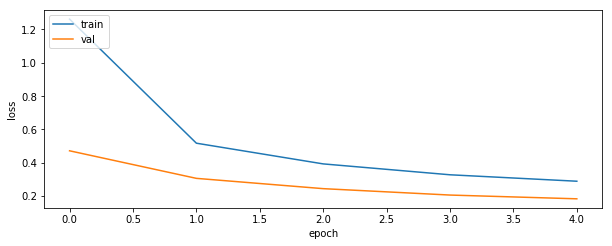

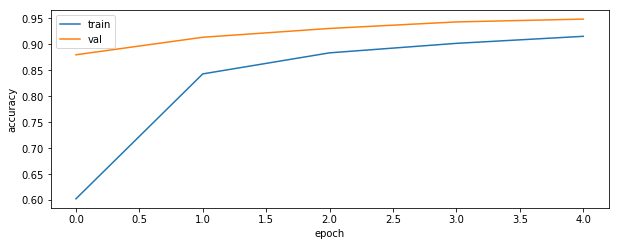

CPU times: user 2min 43s, sys: 8.12 s, total: 2min 51s
Wall time: 2min 52s


In [38]:
%%time 

# Create a ConvNet classifier with 2 CONV-RELU-POOL layers, with 7x7 filters, 
# 32 and 64 output features and a hidden linear layer size of 512.
model_params = {
        'input_size': 784,
        'output_size': 10,
        'filter_sizes': [5],
        'output_depths': [4],
        'hidden_linear_size': 128,
        'use_batch_norm': False
}

training_params = {
        'keep_prob': 0.5,
        'num_epochs': 5,
        'batch_size': 50,
        'stop_early': False,
}

trained_model, training_results, conv_weights = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True
)

The ConvNet classifier takes quite a long time to train, but gives a very respectable test accuracy of over **99%**! 

## What has the network learned?
Remember that a filter in a convolutional layer is used to multiply blocks in the input volume. Let's plot the weights of the first layer of the trained model. Darker pixels indicate that the particular filter reacts more strongly to those regions of the input blocks. Notice how each filter has learned to react differently to different patterns in the input. It's tricky to see in our tiny filters, but those in lower layers of ConvNets, particularly when applied to natural images, often function as simple Gabor filters or edge detectors, while filters in higher layers often react to more abstract shapes and concepts. 



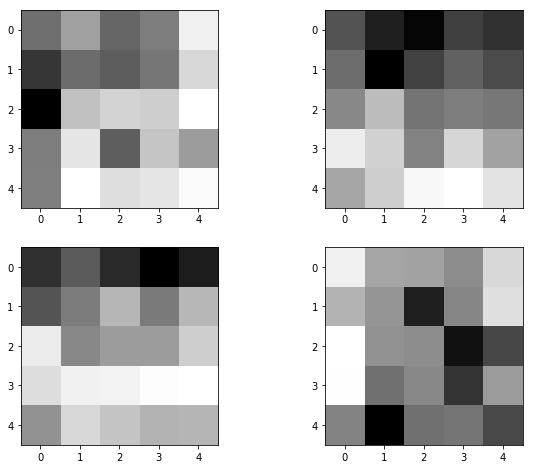

In [39]:
weights = conv_weights[0]
_, _, _, out_depth = weights.shape
grid_size = int(out_depth**0.5)

fig = plt.figure()

i = 1
for r in range(grid_size):
    for c in range(grid_size):
        ax = fig.add_subplot(grid_size, grid_size, i)
        ax.imshow(weights[:, :, 0, r*grid_size+c], cmap="Greys")
        i += 1
plt.show()

# Aside: The Effect of Random Initialization - RUN THIS ON A GPU INSTANCE ONLY!
Initialization of model parameters matters! Here is a ConvNet with different, but seemingly sensible, initialization of the weights in the linear layer. Running this gives significantly worse results. Judging by the accuracy plot, it's possible that training this model long enough will get it to a simliar level as before, but it will take much longer. This shows that initialization of model parameters is a an important consideration, especially as models become more complex. In practice, there are a number of different initialization schemes to consider. In particular, [Xavier](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) tends to work well with ConvNets and is worth considering. We won't go into any details in this practical though.

Epoch: 0001 Training cost= 95.223685306
Epoch: 0001 Validation acc= 0.323000014
Epoch: 0002 Training cost= 4.522310467
Epoch: 0002 Validation acc= 0.294400007
Epoch: 0003 Training cost= 3.359841522
Epoch: 0003 Validation acc= 0.372599989
Epoch: 0004 Training cost= 2.702690359
Epoch: 0004 Validation acc= 0.417400002
Epoch: 0005 Training cost= 2.234992374
Epoch: 0005 Validation acc= 0.439799994
Epoch: 0006 Training cost= 1.954660964
Epoch: 0006 Validation acc= 0.479999989
Epoch: 0007 Training cost= 1.770798251
Epoch: 0007 Validation acc= 0.509599984
Epoch: 0008 Training cost= 1.644968104
Epoch: 0008 Validation acc= 0.519200027
Epoch: 0009 Training cost= 1.517993350
Epoch: 0009 Validation acc= 0.584399998
Epoch: 0010 Training cost= 1.381812039
Epoch: 0010 Validation acc= 0.646399975
Epoch: 0011 Training cost= 1.280346963
Epoch: 0011 Validation acc= 0.657599986
Epoch: 0012 Training cost= 1.202895438
Epoch: 0012 Validation acc= 0.695400000
Epoch: 0013 Training cost= 1.134407729
Epoch: 0013 

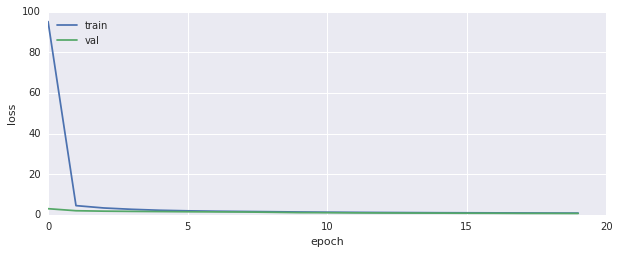

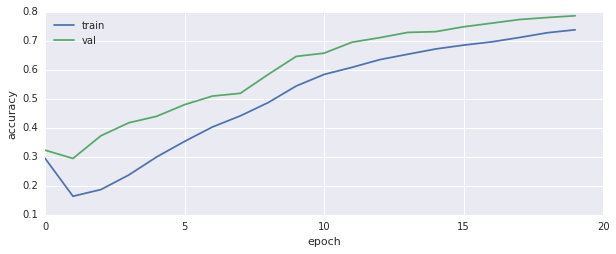

CPU times: user 3h 38min 22s, sys: 14min 55s, total: 3h 53min 18s
Wall time: 29min 29s


In [24]:
%%time 

# Create a ConvNet classifier with 2 CONV-RELU-POOL layers, with filter sizes of 
# 5 and 5 and 32 and 64 output features.
model_params = {
        'input_size': 784,
        'output_size': 10,
        'filter_sizes': [5, 5],
        'output_depths': [32, 64],
        'hidden_linear_size': 1024,
        'use_batch_norm': False
        'linear_weights_initializer': tf.random_normal_initializer()
}

training_params = {
        'keep_prob': 0.5,
        'num_epochs': 5,
        'batch_size': 50,
        'stop_early': False,
}

trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True
)

## Batch Normalisation
Batch normalisation (batch norm) is a more recent (2015) and arguably more powerful normalisation technique than dropout. It is based on the observation that machine learning models often perform better and train faster when their inputs are normalised to have 0 mean and unit variance. In multi-layered deep neural networks, the output of one layer becomes the input to the next. The insight behind batch norm is that each of these layer inputs can also be normalised. Batch norm has been shown to have numerous benefits including:
* Networks tend to train faster
* Allows higher learning rates to be used (further improving training speed).
* Reduced sensitivity to weight initialisation.
* Makes certain activation functions feasible in deep networks (When inputs have very large (absolute) expected values, certain activation functions become saturated (For example, the output of sigmoid is always to 1 for large inputs). Relu activations can also "die out" when the expected value of the input is a large negative value (why?). This results in wasted computation as these neurons become uninformative. Normalising the inputs to have 0 mean keeps these activation functions in the "sensible" parts of their domains.)

### How does it work? 
To normalise some inputs X, ideally we would like to set
$\hat X = \frac{X - E[X]}{\sqrt{VAR[X]}}$
but this requires knowledge of the population mean and variance statistics, which we don't know, at least during training. We therefore use the **sample mean** and **sample variance** of each batch encountered during training as unbiased estimates of these statistics. During testing, we use statistics gathered throughout training as better estimates of the population statistics. In addition to this, we would like the model to have some flexibility over the extent to which batch norm is applied, and this flexibility should be learned! In order to do this, we introduce two new trainable parameters, $\gamma$ and $\beta$ for each layer that batch norm is applied to. Suppose we have a batch of inputs to a layer, $B={x_1,...,x_m}$, we normalise these as follows: 

$\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i$ &nbsp;&nbsp;&nbsp; (Batch mean)

${\sigma_B}^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2$ &nbsp;&nbsp;&nbsp; (Batch variance)
 
$\hat x_i= \frac{x_i - \mu_B}{\sqrt{{\sigma_B}^2}}$ &nbsp;&nbsp;&nbsp; (Normalised)

$y_i = \gamma \hat x_i + \beta$ &nbsp;&nbsp;&nbsp; (Scale and shift)


At test time, we normalise using the mean and variance computed over the entire training set:

$E[x] = E_B[\mu_B]$

$VAR[x] = \frac{m}{m-1}E_B[{\sigma_B}^2]$

$\hat x = \frac{x - E[x]}{\sqrt{VAR[x]}}$

$y = \gamma \hat x + \beta$

### Implementation Details
Tracking the mean and variance over the training set can become a little fiddly. Many implementations also use a *moving average* of the batch mean and variance as estimates of the population mean and variance for use during testing. Luckily, TensorFlow provides batch norm out of the box in the form of the `tf.contrib.layers.batch_norm` function. 

Since the behaviour of batch norm changes during training and testing, we need to pass a placeholder input to the function that indicates which phase we are in. Furthermore, the batch norm function uses variable updates to track the moving average mean and variance. These values are not used during training and so TensorFlow's graph execution logic will not naturally run these updates when you run a training step. In order to get around this, the `batch_norm` function adds these update ops to a *graph collection* that we can access in our training function. The following code, which you will see in the `train_tf_model` function retrieves these ops and then adds a *control dependency* to the optimiser step. This effectively tells TensorFlow that the update_ops must be run before the optimizer_step can be run, ensuring that the estimates are updated whenever we do a training step. 

```
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_step = optimizer_fn.minimize(loss)
```

Further choices to consider when using batch norm are where to apply it (some apply it immediately before each activation function, some *after* the activation function), whether to apply it to all layers and whether or not to *share* the gamma and beta parameters over all layers or have separate values for each layer. . 

Have a look at the ConvNetClassifer class above to see what choices were made, try changing these and see what results you get! (See the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm) for a list of even more parameters you can experiment with)

Now, finally, let's switch batch norm on and see how our ConvNetClassifier performs. (Note: we shouldn't expect it to necessarily perform better than dropout as we are already close to the limits of how well we can classify MNIST with our relatively small ConvNet!)


Epoch: 0001 Training cost= 0.316522977
Epoch: 0001 Validation acc= 0.127800003
Epoch: 0002 Training cost= 0.099678086
Epoch: 0002 Validation acc= 0.174600005
Epoch: 0003 Training cost= 0.062110167
Epoch: 0003 Validation acc= 0.677200019
Epoch: 0004 Training cost= 0.046187922
Epoch: 0004 Validation acc= 0.949800014
Epoch: 0005 Training cost= 0.036256776
Epoch: 0005 Validation acc= 0.981000006
Epoch: 0006 Training cost= 0.026549975
Epoch: 0006 Validation acc= 0.984600008
Epoch: 0007 Training cost= 0.021220099
Epoch: 0007 Validation acc= 0.989600003
Epoch: 0008 Training cost= 0.018451589
Epoch: 0008 Validation acc= 0.991999984
Epoch: 0009 Training cost= 0.015217619
Epoch: 0009 Validation acc= 0.991800010
Epoch: 0010 Training cost= 0.013219205
Epoch: 0010 Validation acc= 0.989799976
Epoch: 0011 Training cost= 0.010857335
Epoch: 0011 Validation acc= 0.990999997
Epoch: 0012 Training cost= 0.009771569
Epoch: 0012 Validation acc= 0.991400003
Epoch: 0013 Training cost= 0.008388710
Epoch: 0013 V

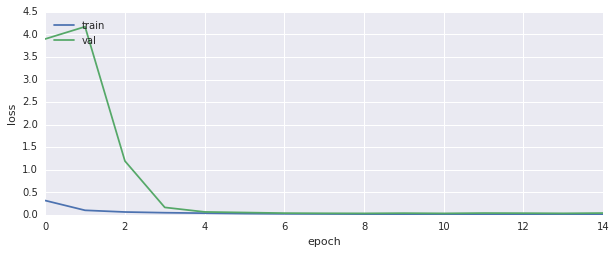

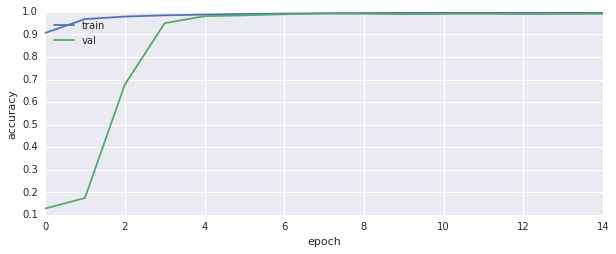

CPU times: user 5h 23min 49s, sys: 16min 2s, total: 5h 39min 51s
Wall time: 14min 30s


In [13]:
%%time 

## UNFORTUNATELY THIS WILL ALSO NOT WORK ON THE VM's, YOU'LL NEED TO GET A GPU INSTANCE TO RUN THIS!

# Create a ConvNet classifier with 2 CONV-RELU-POOL layers, with filter sizes of 
# 5 and 5 and 32 and 64 output features.
model_params = {
        'input_size': 784,
        'output_size': 10,
        'filter_sizes': [5, 5],
        'output_depths': [32, 64],
        'use_batch_norm': True,
}

training_params = {
        'keep_prob': 1.0,    # Switch off dropout
        'num_epochs': 15,
        'batch_size': 50,
        'stop_early': False,
}

trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True
)

# QUESTION: Try experimenting with different archictures and hyperparameters and 
# see how well you can classify MNIST digits! 

# NB: Before you go (5min)

Pair up with someone else and go through the questions in "Learning Objectives" at the top. Take turns explaining each of these to each other, and be sure to ask the tutors if you're both unsure!

# Additional resources

* Chip Huyen's wonderful script: https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/07_convnet_mnist.py
* NVidia's ConvNet Tutorial: https://github.com/alrojo/tensorflow-tutorial/blob/master/lab2_CNN/lab2_CNN.ipynb
* https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab2/lab2_CNN.ipynb

# Feedback

Please send any bugs and comments to dli-practicals@googlegroups.com.